In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import mysql.connector
import numpy as np



db = mysql.connector.connect(host="localhost",
                            username="root",
                            password="Amit@123",
                            database="ecommerse")

cur = db.cursor()



ProgrammingError: 1049 (42000): Unknown database 'ecommerse'

# list all unique cities where customers are located.

In [5]:
query = '''select distinct customer_city from customers'''
cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns = ["Unique_customer_city"])
df.head()


,Unique_customer_city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


#  Count the number of orders placed in 2017.

In [52]:
query = ''' select count(order_id) from orders where year(order_purchase_timestamp)=2017'''

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["number_of_orders"])
df.head()

,number_of_orders
0,45101


# Find the total selse per category.

In [2]:
query = ''' SELECT 
   upper( products.product_category) AS category,
   round(SUM(payments.payment_value),2) AS sales
FROM
    products
        JOIN
    order_items ON products.product_id = order_items.product_id
        JOIN
    payments ON payments.order_id = order_items.order_id
GROUP BY product_category'''

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns=["product_category","sales"])
df.head(20)






,product_category,sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
5,COMPUTER ACCESSORIES,1585330.45
6,HOUSEWARES,1094758.13
7,BABIES,539845.66
8,TOYS,619037.69
9,FURNITURE OFFICE,646826.49


# calculate the percentage of that were paid in installment

In [5]:
query = ''' SELECT 
    (SUM(CASE
        WHEN payment_installments >= 1 THEN 1
        ELSE 0
    END)) / COUNT(*) * 100 AS percentage_payment
FROM
    payments'''

cur.execute(query)
data = cur.fetchall()
print( "percentage of payments",data[0][0])

percentage of payments 99.9981


# count the number of customers from each state. 

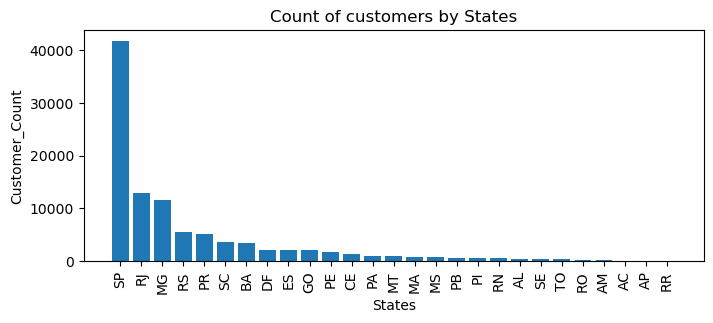

In [25]:
query = '''SELECT 
    COUNT(customer_id), customer_state
FROM
    customers
GROUP BY customer_state'''

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["State","Customer_Count"])
df =df.sort_values(by = "State",ascending= False)
plt.figure(figsize = (8,3))
plt.bar(df["Customer_Count"],df["State"])
plt.xticks(rotation = 90)
plt.xlabel("States")
plt.ylabel("Customer_Count")
plt.title("Count of customers by States")

plt.show()


# calculate the number of orders per month in 2018.

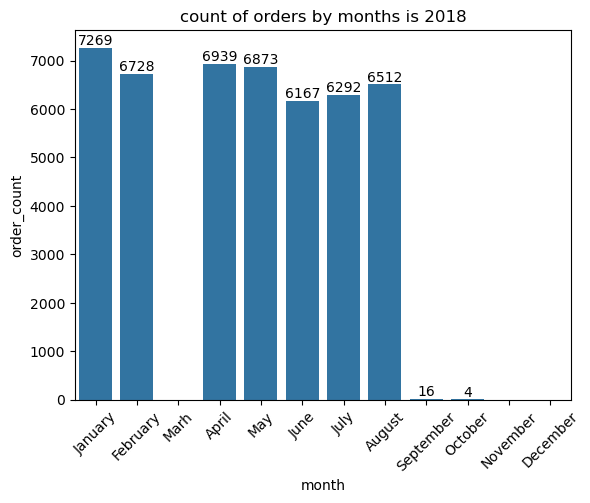

In [26]:
query = '''SELECT 
    MONTHNAME(order_purchase_timestamp) AS month,
    COUNT(order_id) AS order_count
FROM
    orders
WHERE
    YEAR(order_purchase_timestamp) = 2018
GROUP BY month '''

cur.execute(query)
data = cur.fetchall()
#print("number of order per month is ",data)

df=pd.DataFrame(data ,columns = ["month","order_count"])

o = ["January","February","Marh","April","May","June","July","August","September","October","November","December"]

ax = sns.barplot(x = df["month"], y= df["order_count"],data = df,order=o)
plt.xticks(rotation =45)
ax.bar_label(ax.containers[0])
plt.title("count of orders by months is 2018")
plt.show()

# Find the average number of products per order grouped by customer city

In [28]:
query='''with count_per_orders as (select order_items.order_id,orders.customer_id,count(order_items.order_id) as oc from orders join order_items on orders.order_id=order_items.order_id group by orders.order_id,orders.customer_id) 
select customers.customer_city,round(avg(count_per_orders.oc),2) as average_orders  from customers join count_per_orders on customers.customer_id = count_per_orders.customer_id group by customers.customer_city order by average_orders desc'''

cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns = ["Customer_City","Average_orders"])
df.head(10)


,Customer_City,Average_orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,candido godoi,6.00
3,datas,6.00
4,matias olimpio,5.00
5,morro de sao paulo,4.00
6,cidelandia,4.00
7,picarra,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Calculate the total revenue contributed by each category.

In [2]:
query='''SELECT 
    products.product_category AS category,
    ROUND(SUM(payments.payment_value) / (SELECT 
                    SUM(payment_value)
                FROM
                    payments) * 100,
            2) AS Sales_Percentage
FROM
    products
        JOIN
    order_items ON products.product_id = order_items.product_id
        JOIN
    payments ON payments.order_id = order_items.order_id
GROUP BY product_category
ORDER BY Sales_Percentage DESC'''
cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns = ["Category","Sales_Percentage"])
df.head(10)

,Category,Sales_Percentage
0,bed table bath,10.70
1,HEALTH BEAUTY,10.35
2,computer accessories,9.90
3,Furniture Decoration,8.93
4,Watches present,8.93
5,sport leisure,8.70
6,housewares,6.84
7,automotive,5.32
8,Garden tools,5.24
9,Cool Stuff,4.87


# Identyfiy the correlation between product price and the number of times a product has been purchased.

In [7]:
query='''SELECT 
    products.product_category,
    COUNT(order_items.product_id) AS Order_Count,
    ROUND(AVG(order_items.price), 2) AS average_price
FROM
    products
        JOIN
    order_items ON products.product_id = order_items.product_id
GROUP BY products.product_category;'''
cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns = ["Category","Order_Count","Average_Price"])
df.head(10)

arr1 =df["Order_Count"]
arr2 =df["Average_Price"]
a=np.corrcoef([arr1,arr2])
print("the correlation between price and number of times a product has been purchased is " , a[0][-1])

the correlation between price and number of times a product has been purchased is  -0.10631514167157562


# Calculate the total revenue genrated by each seller and rank them by revanue.

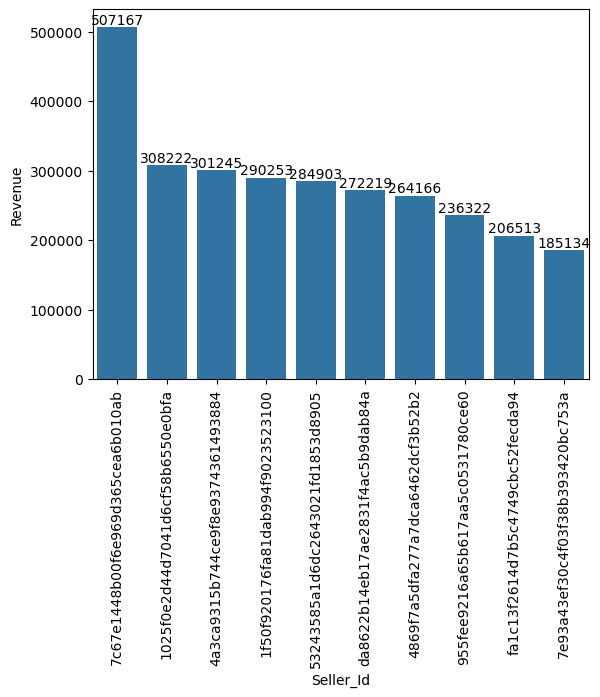

In [16]:
query='''select *, dense_rank() over (order by revenue desc) as rn from 
(select order_items.seller_id,sum(payments.payment_value) as revenue from 
order_items join payments 
on
 order_items.order_id = payments.order_id
 group by order_items.seller_id) as a'''
cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data,columns =["Seller_Id","Revenue","Rank"])
df = df.head(10)
px=sns.barplot(x="Seller_Id",y="Revenue",data = df)
px.bar_label(px.containers[0])
plt.xticks(rotation =90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [20]:
query='''select customer_id,order_purchase_timestamp,payment,avg(payment) 
over (partition by customer_id order by order_purchase_timestamp rows between 2 preceding and current row) as mov_avg from
(SELECT 
    orders.customer_id,
    orders.order_purchase_timestamp,
    payments.payment_value AS payment
FROM
    payments
        JOIN
    orders ON payments.order_id = orders.order_id) as a'''
cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data, columns = ["Seller_Id","order_purchase_timestamp","payment","mov_avg"])
df.head(10)

,Seller_Id,order_purchase_timestamp,payment,mov_avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
5,0004164d20a9e969af783496f3408652,2017-04-12 08:35:12,71.80,71.800003
6,000419c5494106c306a97b5635748086,2018-03-02 17:47:40,49.40,49.400002
7,00046a560d407e99b969756e0b10f282,2017-12-18 11:08:30,166.59,166.589996
8,00050bf6e01e69d5c0fd612f1bcfb69c,2017-09-17 16:04:44,85.23,85.230003
9,000598caf2ef4117407665ac33275130,2018-08-11 12:14:35,1255.71,1255.709961


# Calculate the cumulativ salse per month for each year.

In [4]:
query='''select years,months,payment, sum(payment) 
over (order by years,months) as cumulativ_sales from
(SELECT 
    YEAR(orders.order_purchase_timestamp) AS years,
    MONTH(orders.order_purchase_timestamp) AS months,
    ROUND(SUM(payments.payment_value), 2) AS payment
FROM
    payments
        JOIN
    orders ON payments.order_id = orders.order_id
GROUP BY years , months) as a'''
cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data, columns = ["Years","Months","payment","Cumulative_Sales"])
df.head(10)

,Years,Months,payment,Cumulative_Sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# Calculate the year over year growth rate of total sales.

In [5]:
 query='''with a as  (SELECT 
    YEAR(orders.order_purchase_timestamp) AS years,
    ROUND(SUM(payments.payment_value), 2) AS payment
FROM
    payments
        JOIN
    orders ON payments.order_id = orders.order_id
GROUP BY years)
select years,(payment-lag(payment,1) over(order by years)) / lag(payment,1) over(order by years)*100 from a'''
cur.execute(query)

data=cur.fetchall()

df=pd.DataFrame(data, columns = ["Years","year_by_year_growth"])
df.head()

,Years,year_by_year_growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Identify the top most 3 customers who spent the most money in each year

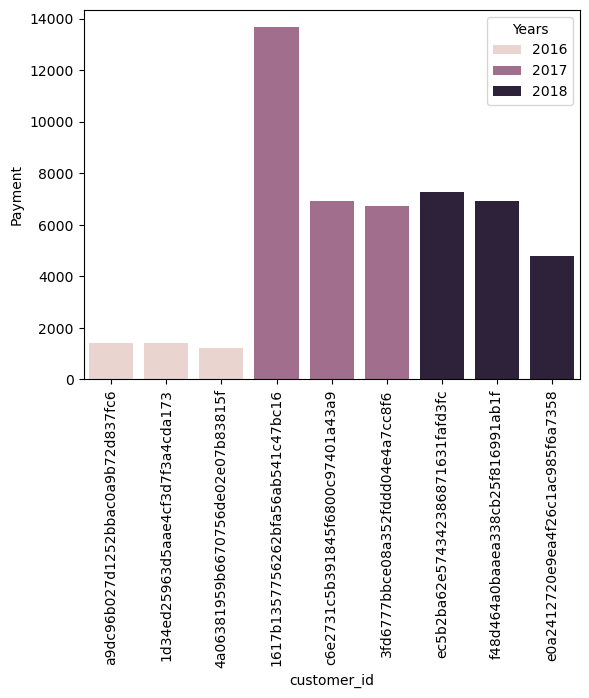

In [14]:
query='''select years,customer_id,payment,D_rank
from
(SELECT 
    year(orders.order_purchase_timestamp) as years	,
    orders.customer_id,
    SUM(payments.payment_value) AS payment ,dense_rank() over (partition by year(order_purchase_timestamp)
    order by sum(payments.payment_value) desc) as D_rank 
FROM
    orders
        JOIN
    payments ON payments.order_id = orders.order_id
GROUP BY  year(order_purchase_timestamp) , orders.customer_id) as a
where D_rank<=3'''

cur.execute(query)
data = cur.fetchall()
df =pd.DataFrame(data,columns=["Years","customer_id","Payment","D_rank"])
df.head(10)

sns.barplot(x="customer_id",y="Payment",data=df,hue= "Years")
plt.xticks(rotation = 90)
plt.show()

# Which 5 states have the highest number of customers?

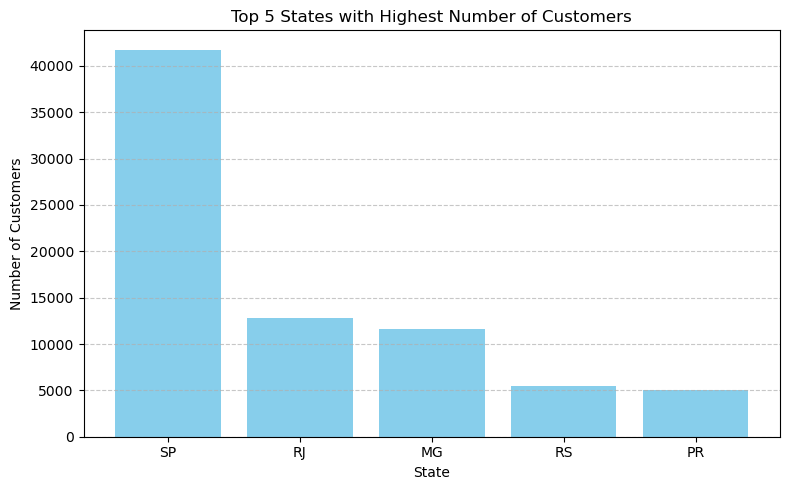

In [7]:
query='''SELECT 
    customer_state,
    COUNT(*) AS total_customers
FROM customers
GROUP BY customer_state
ORDER BY total_customers DESC
LIMIT 5
'''

cur.execute(query)
data = cur.fetchall()
df =pd.DataFrame(data,columns=["State","Number of Customers"])



# Plot
plt.figure(figsize=(8, 5))
plt.bar(df["State"],df["Number of Customers"] ,color='skyblue')
plt.title('Top 5 States with Highest Number of Customers')
plt.xlabel('State')
plt.ylabel('Number of Customers')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Which payment type is most commonly used?

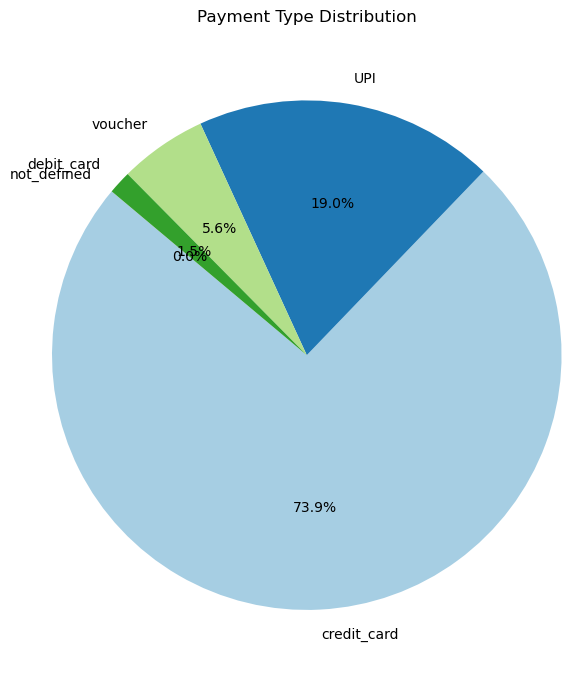

In [26]:


query='''
SELECT 
    payment_type,
    COUNT(*) AS total_payments
FROM payments
GROUP BY payment_type
ORDER BY total_payments DESC
'''

cur.execute(query)
data = cur.fetchall()
df =pd.DataFrame(data,columns=["payment_type","total_payments"])
data
plt.figure(figsize=(6,7 ))
plt.pie(df["total_payments"],
        labels=df["payment_type"],
        autopct='%1.1f%%',
        startangle=140,
        colors=plt.cm.Paired.colors)

plt.title('Payment Type Distribution')
plt.axis('equal')  # Equal aspect ratio ensures pie is a circle.
plt.tight_layout()
plt.show()

# What is the average payment value for each payment type?

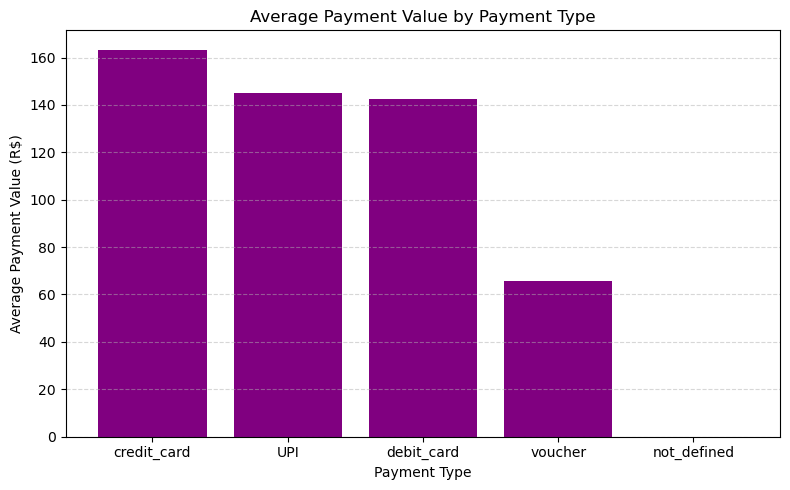

In [49]:

query='''
SELECT 
    payment_type,
    ROUND(AVG(payment_value), 2) AS avg_payment
FROM payments
GROUP BY payment_type
ORDER BY avg_payment DESC

'''

cur.execute(query)
data = cur.fetchall()
df =pd.DataFrame(data,columns=["payment_type","avg_payment"])
df.head()
plt.figure(figsize=(8, 5))
plt.bar(df["payment_type"],df["avg_payment"], color='purple')
plt.title('Average Payment Value by Payment Type')
plt.xlabel('Payment Type')
plt.ylabel('Average Payment Value (R$)')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Top 10 Customers by Total Amount Spent

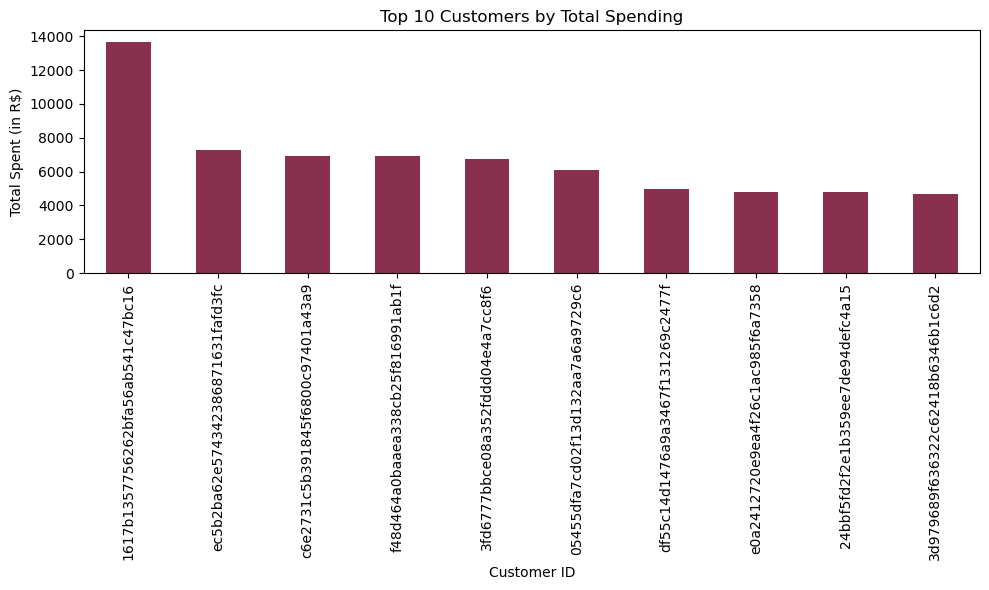

In [11]:


query='''
SELECT 
    c.customer_id,
    ROUND(SUM(p.payment_value), 2) AS total_spent
FROM orders o
JOIN customers c ON o.customer_id = c.customer_id
JOIN payments p ON o.order_id = p.order_id
GROUP BY c.customer_id
ORDER BY total_spent DESC
LIMIT 10;


'''

cur.execute(query)
data = cur.fetchall()
df =pd.DataFrame(data,columns=["customer_id","total_spent"])
df.head()

df.plot(kind='bar', x='customer_id', y='total_spent',color="#88304E", legend=False, figsize=(10,6))
plt.title('Top 10 Customers by Total Spending')
plt.ylabel('Total Spent (in R$)')
plt.xlabel('Customer ID')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


# Monthly Revenue Trend

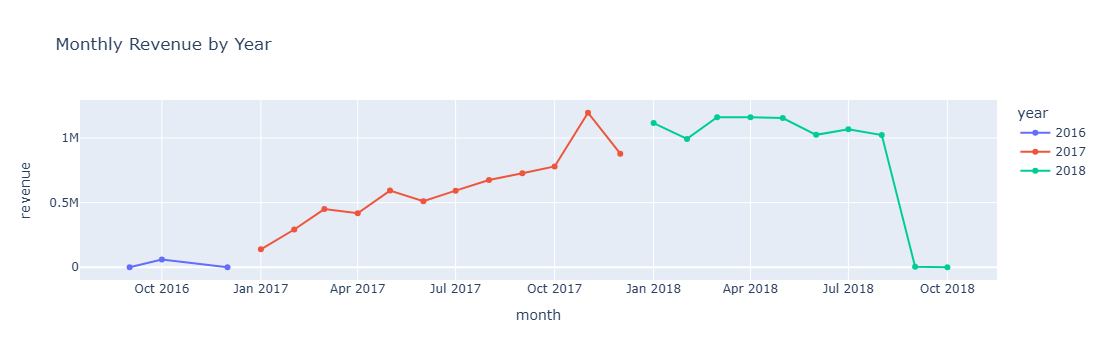

In [29]:

query='''
SELECT 
    DATE_FORMAT(order_purchase_timestamp, '%Y-%m') AS month,
    ROUND(SUM(p.payment_value), 2) AS revenue
FROM orders o
JOIN payments p ON o.order_id = p.order_id
GROUP BY month
ORDER BY month;


'''

cur.execute(query)
data = cur.fetchall()
df =pd.DataFrame(data,columns=["month","revenue"])
df.head()


#fig = px.line(df, x='month', y='revenue',title='Monthly Revenue Trend')
#fig.update_traces(mode='lines+markers')
#fig.show()

df['year'] = df['month'].str[:4]  # Extract year

fig = px.line(df, x='month', y='revenue', color='year', title='Monthly Revenue by Year')
fig.update_traces(mode='lines+markers')
fig.show()


# Sellers with the Highest Number of Orders

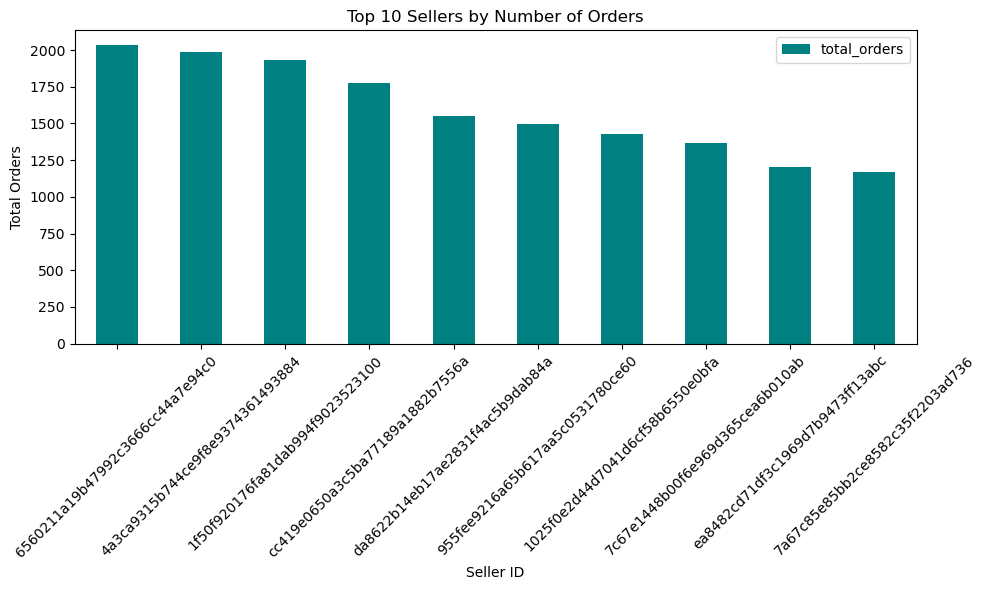

In [23]:

query='''
SELECT 
    s.seller_id,
    COUNT(oi.order_id) AS total_orders
FROM order_items oi
JOIN sellers s ON oi.seller_id = s.seller_id
GROUP BY s.seller_id
ORDER BY total_orders DESC
LIMIT 10;

'''

cur.execute(query)
data = cur.fetchall()
df =pd.DataFrame(data,columns=["seller_id","total_orders"])
df.head()

df.plot(kind='bar', x='seller_id', y='total_orders', figsize=(10,6), color='teal')
plt.title('Top 10 Sellers by Number of Orders')
plt.xlabel('Seller ID')
plt.ylabel('Total Orders')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Delivery Delay vs Estimated Delivery

In [25]:


query='''
SELECT 
    ROUND(AVG(DATEDIFF(o.order_delivered_customer_date, o.order_estimated_delivery_date)), 2) AS avg_delay
FROM orders o
WHERE o.order_status = 'delivered';

'''

cur.execute(query)
data = cur.fetchall()
df =pd.DataFrame(data,columns=["avg_delay"])
df.head()

,avg_delay
0,-11.88


# Visualization: If multiple orders per month are available, show delays over time:

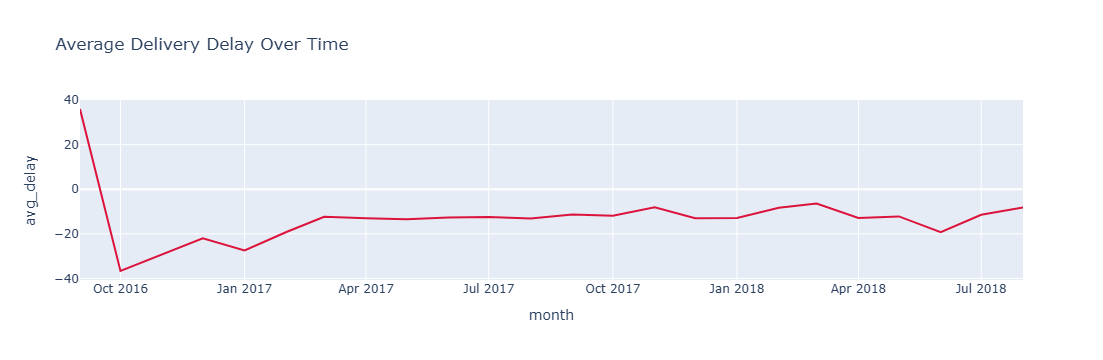

In [27]:


query='''
SELECT 
    DATE_FORMAT(order_purchase_timestamp, '%Y-%m') AS month,
    ROUND(AVG(DATEDIFF(order_delivered_customer_date, order_estimated_delivery_date)), 2) AS avg_delay
FROM orders
WHERE order_status = 'delivered'
GROUP BY month
ORDER BY month;

'''

cur.execute(query)
data = cur.fetchall()
df =pd.DataFrame(data,columns=["month","avg_delay"])
df.head()

fig = px.line(df, x='month', y='avg_delay', title='Average Delivery Delay Over Time')
fig.update_traces(line_color='crimson')
fig.show()


# Product Category Return Rate (if return/canceled status present)

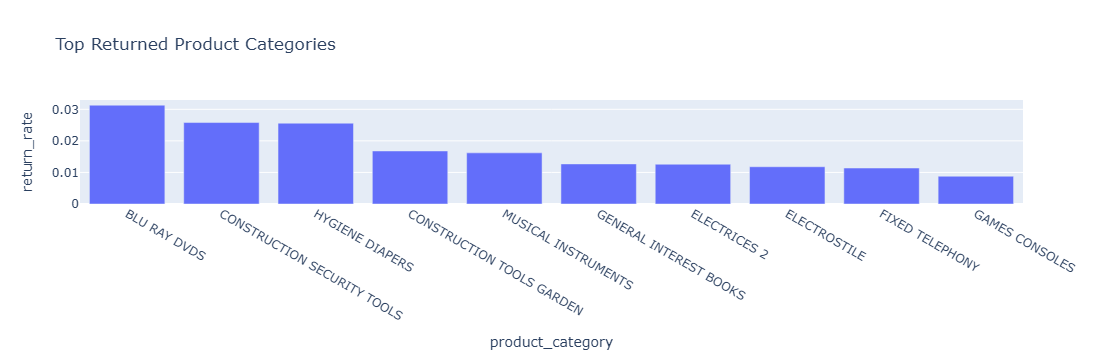

In [33]:


query='''
SELECT 
    upper(product_category),
    COUNT(CASE WHEN o.order_status = 'canceled' THEN 1 END) / COUNT(*) AS return_rate
FROM order_items oi
JOIN products pr ON oi.product_id = pr.product_id
JOIN orders o ON oi.order_id = o.order_id
GROUP BY product_category
HAVING COUNT(*) > 20
ORDER BY return_rate DESC
LIMIT 10;

'''

cur.execute(query)
data = cur.fetchall()
df =pd.DataFrame(data,columns=["product_category","return_rate"])
df.head()

fig = px.bar(df, x='product_category', y='return_rate', title='Top Returned Product Categories')
fig.show()
